In [35]:
!pip install pycocotools

In [0]:
#cloning the object detection API

import os
import pathlib
import cv2

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/mittshah2/models.git

In [37]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [38]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1082275 sha256=757a88aff9133da008c91c06fe89ccc2c9a21305dd01a4aaa114b379efb703f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-ugq6x71w/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import tensorflow as tf
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
import math

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
import os
os.chdir('/content/models/research/object_detection')
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

In [0]:
#for linux users

!sudo apt-get install ttf-mscorefonts-installer
!sudo fc-cache
!fc-match Arial

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

Tensorflow 1.15 and numpy 1.16 requied to train the model

In [0]:
!pip install tensorflow==1.15
!pip install numpy==1.16

In [0]:
print(tf.__version__)

In [0]:
!python model_main.py --model_dir=/content/drive/'My Drive'/mask_detection/records --pipeline_config_path=/content/drive/'My Drive'/mask_detection/pipeline.config

In [0]:
#exporting the inference graph to results directory

!python export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path /content/drive/'My Drive'/mask_detection/pipeline.config \
    --trained_checkpoint_prefix /content/drive/'My Drive'/mask_detection/records/model.ckpt-8895 \
    --output_directory /content/drive/'My Drive'/mask_detection/results

Install tensorflow 2 for loading the model

In [0]:
!pip install tensorflow==2.2.0

In [0]:
print(tf.__version__)

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [0]:
def show_inference_face(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  shape=image_np.shape
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  img=output_dict['detection_boxes'][0]
  img[0]=math.ceil(img[0]*shape[0])
  img[1]=math.ceil(img[1]*shape[0])
  img[2]=math.ceil(img[2]*shape[1])
  img[3]=math.ceil(img[3]*shape[1])
  img=image_np[int(img[0]):int(img[2]),int(img[1]):int(img[3])]
  return img

In [0]:
def show_inference(model, image_np):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      font_size=25,
      line_thickness=5)

  display(Image.fromarray(image_np))

Loading saved model

In [0]:
PATH_TO_LABELS='/content/drive/My Drive/mask_detection/ssd_mobilenet_v1_coco_2018_01_28/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_model():
  model_dir = '/content/drive/My Drive/mask_detection/results'

  model_dir = pathlib.Path(model_dir)/"saved_model"
  
  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [0]:
def load_model_face(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"
  
  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [50]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
face_model = load_model_face(model_name)
mask_model=load_model()

76537856/76534733 [==============================] - 1s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


[1]


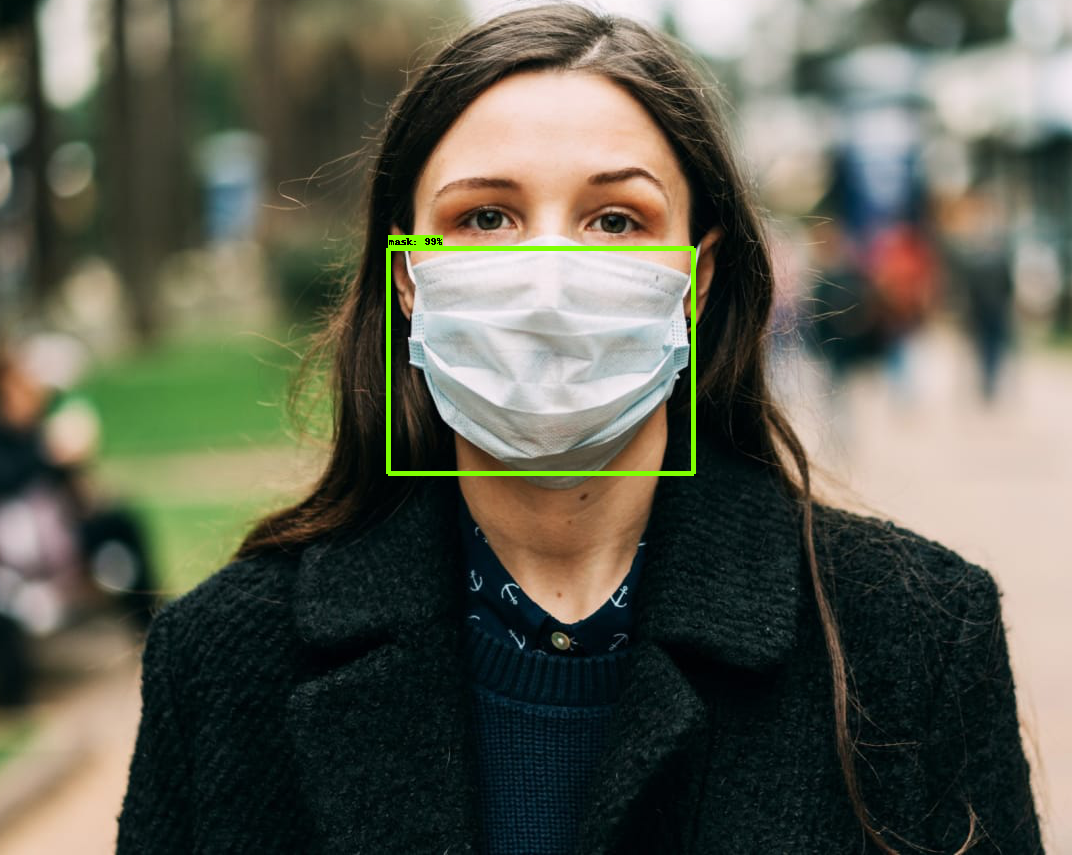

In [55]:
img=show_inference_face(face_model,'/content/1.jpg')
show_inference(mask_model,img)

Loading inference graph(an alternate method to use custom model)(requires tf=1.15)


In [0]:
# !pip install tensorflow==1.15

In [0]:
# MODEL_NAME='/content/drive/My Drive/mask_detection/results'
# PATH_TO_CKPT=MODEL_NAME+'/frozen_inference_graph.pb'
# PATH_TO_LABELS='/content/drive/My Drive/mask_detection/ssd_mobilenet_v1_coco_2018_01_28/label_map.pbtxt'
# category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
# NUM_CLASSES=1

In [0]:
# detection_graph=tf.Graph()
# with detection_graph.as_default():
#   od_graph_def=tf.GraphDef()
#   with tf.gfile.GFile(PATH_TO_CKPT,'rb') as fid:
#     serialized_graph=fid.read()
#     od_graph_def.ParseFromString(serialized_graph)
#     tf.import_graph_def(od_graph_def,name='')

In [0]:
# with detection_graph.as_default():
#   with tf.Session(graph=detection_graph) as sess:
#    image_path='/content/1.jpg'
#    image_np = np.array(Image.open(image_path))
#    image_np_expanded=np.expand_dims(image_np,axis=0)
#    image_tensor=detection_graph.get_tensor_by_name('image_tensor:0')
#    boxes=detection_graph.get_tensor_by_name('detection_boxes:0')
#    scores=detection_graph.get_tensor_by_name('detection_scores:0')
#    classes=detection_graph.get_tensor_by_name('detection_classes:0')
#    num_detections=detection_graph.get_tensor_by_name('num_detections:0')
#    (boxes,scores,classes,num_detections)=sess.run(
#        [boxes,scores,classes,num_detections],
#        feed_dict={image_tensor:image_np_expanded})
#    vis_util.visualize_boxes_and_labels_on_image_array(
#        image_np,
#        np.squeeze(boxes),
#        np.squeeze(classes).astype(np.int32),
#        np.squeeze(scores),
#        category_index,
#        use_normalized_coordinates=True,
#        font_size=45,
#       line_thickness=5
#    )
#   display(Image.fromarray(image_np))